# Modelling tides

[![Download Jupyter Notebook](https://img.shields.io/badge/Jupyter%20Notebook-Download%20on%20GitHub-F37626?logo=jupyter&logoColor=white)](https://github.com/GeoscienceAustralia/eo-tides/blob/main/docs/notebooks/Model_tides.ipynb)
[![Python API Reference](https://img.shields.io/badge/Python-API%20Reference-3776AB?logo=python&logoColor=white)](../../api/#eo_tides.model)

**This guide demonstrates how to use the [`model_tides`](../../api/#eo_tides.model.model_tides) and [`model_phases`](../../api/#eo_tides.model.model_phases) functions from the [`eo_tides.model`](../../api/#eo_tides.model) module to model tide heights and phases at multiple coordinates or time steps, using one or more ocean tide models.**

---

The `model_tides` function supports tide modelling based on a wide range of ocean tide models using a single line of code, parallelising this modelling where possible and returning data in a standardised `pandas.Dataframe` format.
The `model_tides` function can be used independently of Earth observation (EO) data, e.g. for any application where you need to generate a time series of tide heights.
However, it also underpins the more complex EO-related functions demonstrated in [Combining tides with satellite data](../Satellite_data).

The `model_phases` function can be used to model the phase of the tide at any location and time.
This can be used to classify tides into high and low tide observations, or determine whether the tide was rising (i.e. flow tide) or falling (i.e. ebb tide).

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        The <code>model_tides</code> function is based on the <a href="https://pytmd.readthedocs.io/en/latest/api_reference/compute.html#pyTMD.compute.tide_elevations"><code>pyTMD.compute.tide_elevations</code></a> function from the <code>pyTMD</code> tide modelling package that underpins <code>eo-tides</code>. We highly recommend exploring the <a href="https://pytmd.readthedocs.io/en/latest/">more advanced tide modelling functionality available in <code>pyTMD</code></a> for more custom tide modelling applications.
    </p>
</div>

## Getting started
As a first step, we need to tell `eo-tides` the location of our tide model directory (if you haven't set this up, [refer to the setup instructions here](../../setup)).

We will pass this path to `eo-tides` functions using the `directory` parameter.

<!-- For local installation:
pip install -e ../../. -->

In [1]:
directory = "../../tests/data/tide_models/"

<div class="admonition important">
    <p class="admonition-title">Important</p>
    <p>
        The directory above is for demo purposes only.
        Update the <code>directory</code> path to point to the location of your own tide model directory.
    </p>
</div>

We can use the [`eo_tides.utils.list_models`](../../api/#eo_tides.utils.list_models) function to verify that we have tide model data available in this directory:

In [2]:
from eo_tides.utils import list_models

list_models(directory=directory, show_supported=False);

────────────────────────────────────────────────────────────────────────────────
 󠀠🌊  | Model                | Expected path                                                   
────────────────────────────────────────────────────────────────────────────────
 ✅  │ EOT20                │ ../../tests/data/tide_models/EOT20/ocean_tides                  
 ✅  │ GOT5.5               │ ../../tests/data/tide_models/GOT5.5/ocean_tides                 
 ✅  │ HAMTIDE11            │ ../../tests/data/tide_models/hamtide                            
────────────────────────────────────────────────────────────────────────────────

Summary:
Available models: 3/52


## Using model_tides

In the example below, we use the [`model_tides`](../../api/#eo_tides.model.model_tides) function to model hourly tides for the city of **Broome, Western Australia** across **January 2018**.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        To learn more about the science of tide prediction, refer to the <code>pyTMD</code> <a href="https://pytmd.readthedocs.io/en/latest/background/Background.html">Background documentation</a> and <a href="https://pytmd.readthedocs.io/en/latest/background/Glossary.html">Glossary</a>.
    </p>
</div>

In [3]:
import pandas as pd

from eo_tides.model import model_tides

tide_df = model_tides(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-31", freq="1h"),
    directory=directory,
)

# Print outputs
tide_df.head()

Modelling tides with EOT20


,,,tide_model,tide_height
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,EOT20,1.229286
2018-01-01 01:00:00,122.2186,-18.0008,EOT20,2.162897
2018-01-01 02:00:00,122.2186,-18.0008,EOT20,2.476600
2018-01-01 03:00:00,122.2186,-18.0008,EOT20,2.112390
2018-01-01 04:00:00,122.2186,-18.0008,EOT20,1.181283


<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        If you do not see an output after running this code (e.g. for example if you are running the code as a script in a terminal, VS Code, or another code editor instead of a Jupyter Notebook), you may need to run <code>print(tide_df.head())</code> instead.
    </p>
</div>

The resulting `pandas.DataFrame` contains:

* `time`, `x`, `y`: Our original input timesteps and coordinates
* `tide_model`: a column listing the tide model used
* `tide_height`: modelled tide heights representing tide height in metres relative to Mean Sea Level

We can plot our modelled outputs to view how tides changed across the month. 
Looking at the y-axis, we can see that tides at this macrotidal region ranged from -4 metres up to a maximum of +4 metres relative to Mean Sea Level:

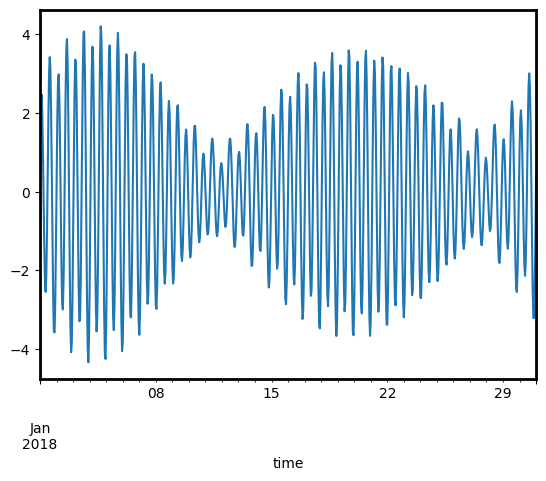

In [4]:
tide_df.droplevel(["x", "y"]).tide_height.plot();

### Multiple models

By default, `model_tides` will model tides using the [`EOT20` tide model](https://www.seanoe.org/data/00683/79489/) – a leading open-source global ocean model with a permissive CC BY 4.0 licence:

> Hart-Davis Michael, Piccioni Gaia, Dettmering Denise, Schwatke Christian, Passaro Marcello, Seitz Florian (2021). EOT20 - A global Empirical Ocean Tide model from multi-mission satellite altimetry. SEANOE. https://doi.org/10.17882/79489

However, we can easily model tides using multiple models by passing a list of models to the `model` parameter.
`eo-tides` will process these in parallel where possible, and return the data into a single `pandas.DataFrame`.
For example, we can model tides using the `EOT20`, `GOT5.5` and `HAMTIDE11` models:

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Here we also set <code>output_format="wide"</code>, which will place data from each model into a new column.
        This can make it easier to plot our data. For more details, <a href="#wide-and-long-output-formats">see below</a>.
    </p>
</div>

In [5]:
tide_df_multiple = model_tides(
    x=122.2186,
    y=-18.0008,
    model=["EOT20", "HAMTIDE11", "GOT5.5"],
    time=pd.date_range(start="2018-01-01", end="2018-01-31", freq="1h"),
    output_format="wide",
    directory=directory,
)

# Print outputs
tide_df_multiple.head()

Modelling tides with EOT20, HAMTIDE11, GOT5.5 in parallel (models: 3, splits: 1)


100%|██████████| 3/3 [00:00<00:00, 11.90it/s]


Converting to a wide format dataframe


,,tide_model,EOT20,GOT5.5,HAMTIDE11
time,x,y,,,
2018-01-01 00:00:00,122.2186,-18.0008,1.229286,1.298428,1.422702
2018-01-01 01:00:00,122.2186,-18.0008,2.162897,2.287205,2.302042
2018-01-01 02:00:00,122.2186,-18.0008,2.476600,2.618187,2.537032
2018-01-01 03:00:00,122.2186,-18.0008,2.112390,2.228045,2.072845
2018-01-01 04:00:00,122.2186,-18.0008,1.181283,1.241291,1.034931


Plot our outputs to see all our models on a graph:

<Axes: xlabel='time'>

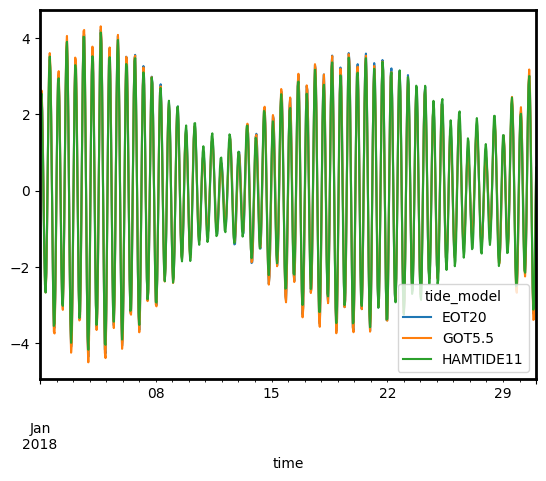

In [6]:
# Print outputs
tide_df_multiple.droplevel(["x", "y"]).plot(legend=True)

### "One-to-many" and "one-to-one" modes

By default, the `model_tides` function operates in **"one-to-many"** mode, which will model tides at every requested location, for every requested timestep.
This is particularly useful for satellite Earth observation applications where we may want to model tides for every satellite acquisition through time, for a large set of satellite pixels.

For example, if we provide two locations and two timesteps, the function will return four modelled tides:
```
2 locations * 2 timesteps = 4 modelled tides
```

In [7]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-31", periods=2),
    mode="one-to-many",
    directory=directory,
)

Modelling tides with EOT20


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,EOT20,1.231424
2018-01-31,122.21,-18.20,EOT20,0.368303
2018-01-01,122.22,-18.21,EOT20,1.231424
2018-01-31,122.22,-18.21,EOT20,0.368303


However, another common use case is having a list of locations you want to use to model tides for, each with a single timestep.
Using **"one-to-one"** mode, we can model tides for each pair of locations and times:
```
2 timesteps at 2 locations = 2 modelled tides
```

For example, you may have a `pandas.DataFrame` containing `x`, `y` and `time` values:

In [ ]:
tide_df = pd.DataFrame({
    "time": pd.date_range(start="2018-01-01", end="2018-01-31", periods=2),
    "x": [122.21, 122.22],
    "y": [-18.20, -18.21],
})
tide_df

,time,x,y
0,2018-01-01,122.21,-18.20
1,2018-01-31,122.22,-18.21


We can pass these values to `model_tides` directly, and run the function in "one-to-one" mode to return a tide height for each row:

In [ ]:
# Model tides and add back into dataframe
tide_df["tide_height"] = model_tides(
    x=tide_df.x,
    y=tide_df.y,
    time=tide_df.time,
    mode="one-to-one",
    directory=directory,
).tide_height.to_numpy()

# Print dataframe with added tide height data:
tide_df.head()

Modelling tides with EOT20


,time,x,y,tide_height
0,2018-01-01,122.21,-18.20,1.231424
1,2018-01-31,122.22,-18.21,0.368303


### "Wide" and "long" output formats
By default, modelled tides will be returned in **"long"** format, with multiple models stacked under a `tide_models` column and tide heights in the `tide_height` column:


In [10]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-31", periods=2),
    model=["EOT20", "GOT5.5", "HAMTIDE11"],
    output_format="long",
    directory=directory,
)

Modelling tides with EOT20, GOT5.5, HAMTIDE11 in parallel (models: 3, splits: 1)


100%|██████████| 3/3 [00:00<00:00, 14.02it/s]


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,EOT20,1.231424
2018-01-31,122.21,-18.20,EOT20,0.368303
2018-01-01,122.22,-18.21,EOT20,1.231424
2018-01-31,122.22,-18.21,EOT20,0.368303
2018-01-01,122.21,-18.20,GOT5.5,1.271818
2018-01-31,122.21,-18.20,GOT5.5,0.397215
2018-01-01,122.22,-18.21,GOT5.5,1.271818
2018-01-31,122.22,-18.21,GOT5.5,0.397215
2018-01-01,122.21,-18.20,HAMTIDE11,1.435844


We can also run the function in **"wide"** format, which will return a new column for each tide model (e.g. `EOT20`, `GOT5.5`, `HAMTIDE11` etc):

In [11]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-31", periods=2),
    model=["EOT20", "GOT5.5", "HAMTIDE11"],
    output_format="wide",
    directory=directory,
)

Modelling tides with EOT20, GOT5.5, HAMTIDE11 in parallel (models: 3, splits: 1)


100%|██████████| 3/3 [00:00<00:00, 13.76it/s]


Converting to a wide format dataframe


tide_model                   EOT20    GOT5.5  HAMTIDE11
time       x      y                                    
2018-01-01 122.21 -18.20  1.231424  1.271818   1.435844
           122.22 -18.21  1.231424  1.271818   1.435844
2018-01-31 122.21 -18.20  0.368303  0.397215   0.588129
           122.22 -18.21  0.368303  0.397215   0.588129

## Using model_phases

In addition to tide height, it can be useful to obtain information about the phase of the tide at each observation. For example, we may want to know whether tides were low or high, or whether water levels were rising ("flow" tide) or falling ("ebb" tide).
Tide phase data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

The `model_phases` function calculates ebb and low phases by modelling tides once for the requested timesteps, and again after shifting each time by a small time offset (by default, 15 minutes).
If tides increased over this period, they are assigned as "flow"; if they decreased, they are assigned as "ebb".
Tides are considered "high" if equal or greater than 0 metres tide height, otherwise "low".

We can run `model_phases` by providing `x` and `y` coordinates and `time`:

In [12]:
from eo_tides.model import model_phases

model_phases(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-02", freq="5h"),
    directory=directory,
)

Modelling tides with EOT20
Modelling tides with EOT20


,,,tide_model,tide_phase
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,EOT20,high-flow
2018-01-01 05:00:00,122.2186,-18.0008,EOT20,low-ebb
2018-01-01 10:00:00,122.2186,-18.0008,EOT20,low-flow
2018-01-01 15:00:00,122.2186,-18.0008,EOT20,high-ebb
2018-01-01 20:00:00,122.2186,-18.0008,EOT20,low-ebb


The resulting `pandas.DataFrame` contains:

* `time`, `x`, `y`: Our original input timesteps and coordinates
* `tide_model`: a column listing the tide model used
* `tide_phase`: the modelled tidal phase ("high-flow", "high-ebb", "low-ebb", "low-flow").

`model_phases` accepts all parameters accepted by `model_tides`; e.g. `model` and `output_format`:


In [13]:
model_phases(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-02", freq="5h"),
    model=["EOT20", "GOT5.5"],
    output_format="wide",
    directory=directory,
)

Modelling tides with EOT20, GOT5.5 in parallel (models: 2, splits: 1)


100%|██████████| 2/2 [00:00<00:00, 14.52it/s]


Modelling tides with EOT20, GOT5.5 in parallel (models: 2, splits: 1)


100%|██████████| 2/2 [00:00<00:00, 15.38it/s]


Converting to a wide format dataframe


,,tide_model,EOT20,GOT5.5
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,high-flow,high-flow
2018-01-01 05:00:00,122.2186,-18.0008,low-ebb,low-ebb
2018-01-01 10:00:00,122.2186,-18.0008,low-flow,low-flow
2018-01-01 15:00:00,122.2186,-18.0008,high-ebb,high-ebb
2018-01-01 20:00:00,122.2186,-18.0008,low-ebb,low-ebb


To change the default 15 minute time offset used to calculate tide phases, pass a custom value to `time_offset`:

In [14]:
model_phases(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-02", freq="5h"),
    time_offset="30 min",
    directory=directory,
)

Modelling tides with EOT20
Modelling tides with EOT20


,,,tide_model,tide_phase
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,EOT20,high-flow
2018-01-01 05:00:00,122.2186,-18.0008,EOT20,low-ebb
2018-01-01 10:00:00,122.2186,-18.0008,EOT20,low-flow
2018-01-01 15:00:00,122.2186,-18.0008,EOT20,high-ebb
2018-01-01 20:00:00,122.2186,-18.0008,EOT20,low-ebb


Optionally, we can choose to return also tide heights by providing `return_tides=True`.
This will include an additional `tide_height` column in our dataframe:

In [15]:
phase_df = model_phases(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-02", freq="30min"),
    return_tides=True,
    directory=directory,
)

# Print outputs
print(phase_df.head())

Modelling tides with EOT20
Modelling tides with EOT20
                                      tide_model  tide_height tide_phase
time                x        y                                          
2018-01-01 00:00:00 122.2186 -18.0008      EOT20     1.229286  high-flow
2018-01-01 00:30:00 122.2186 -18.0008      EOT20     1.763103  high-flow
2018-01-01 01:00:00 122.2186 -18.0008      EOT20     2.162897  high-flow
2018-01-01 01:30:00 122.2186 -18.0008      EOT20     2.405015  high-flow
2018-01-01 02:00:00 122.2186 -18.0008      EOT20     2.476600  high-flow


If we plot our `tide_height` and `tide_phase` data, we can see it follows a logical progression from `high-flow -> high-ebb -> low-ebb -> low-flow -> ...`, repeating with every tide cycle:

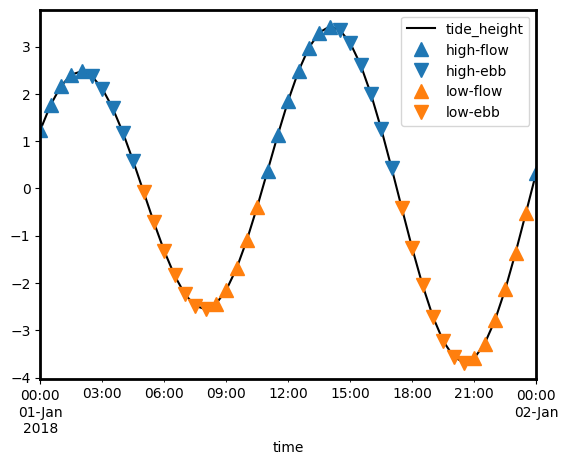

In [16]:
# Plot tide heights
ax = phase_df.droplevel(["x", "y"]).tide_height.plot(color="black")

# Define plotting parameters for each phase
plot_params = {
    "high-flow": {"marker": "^", "color": "tab:blue"},
    "high-ebb": {"marker": "v", "color": "tab:blue"},
    "low-flow": {"marker": "^", "color": "tab:orange"},
    "low-ebb": {"marker": "v", "color": "tab:orange"},
}

# Plot each phase
for phase, params in plot_params.items():
    phase_df.droplevel(["x", "y"]).query(f"tide_phase == '{phase}'").tide_height.plot(
        marker=params["marker"],
        linewidth=0.0,
        color=params["color"],
        markersize=10,
        label=phase,
    )
ax.legend();

## Next steps

Now that we have demonstrated how to model tide heights and phases, we can learn how to [combine modelled tides with satellite data](../Satellite_data) for further analysis.